In [2]:
import os
os.environ['http_proxy'] = 'http://proxy1.bgc-jena.mpg.de:3128' 
os.environ['https_proxy'] = 'http://proxy1.bgc-jena.mpg.de:3128'

FILES TO UPDATE: 
- config.yaml
- params.yaml
- entity
- configuration manager in src config
- components
- pipeline
- main.py
- app.py

In [3]:
os.chdir('../')
%pwd

'/Net/Groups/BGI/scratch/ppandey/Side_Quest/semantic-land-segment-hf'

In [4]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class DataLoaderConfig:
    root_dir: Path
    preprocessed_data_path: Path
    BACKBONE: int
    n_classes: int
    batch_size: int

In [5]:
from landcover_segmentation.constants import *
from landcover_segmentation.utils.common import create_directories, read_yaml

In [6]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILEPATH,
        params_filepath = PARAMS_FILEPATH
    ):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)

        # create artifacts folder
        create_directories([self.config.artifacts_root])

    def get_data_loader_config(self) -> DataLoaderConfig:
        config = self.config.data_loader
        params = self.params.SegmentationModelArguements

        # create directory
        create_directories([config.root_dir])

        data_loader_config = DataLoaderConfig(
            root_dir=config.root_dir,
            preprocessed_data_path=config.preprocessed_data_path,
            BACKBONE=params.BACKBONE,
            n_classes=params.n_classes,
            batch_size=params.batch_size
        )

        return data_loader_config

In [7]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader

from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

import cv2
from PIL import Image

from landcover_segmentation.logging import logger

/Net/Groups/BGI/scratch/ppandey/miniconda3/envs/txtS/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-20 20:35:31.570080: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 20:35:40.549215: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
class DataLoaderSegmentation(torch.utils.data.Dataset):
    def __init__(
        self, 
        imgs_path,
        masks_path,
        img_transform=None,
        mask_transform=None
    ):
        super().__init__()
        self.imgs_path = imgs_path
        self.imgs_list = os.listdir(imgs_path)

        self.masks_path = masks_path
        self.masks_list = os.listdir(masks_path)

        self.img_transform = img_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.imgs_list)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.imgs_path, self.imgs_list[idx])
        mask_path = os.path.join(self.masks_path, self.masks_list[idx])
        img = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.img_transform is not None and self.mask_transform is not None:
            img = self.img_transform(img)
            mask = self.mask_transform(mask)

        return (img, mask)
    
    def get_image_paths(self):
        return [os.path.join(self.imgs_path, img) for img in self.imgs_list]


(-0.5, 255.5, 255.5, -0.5)

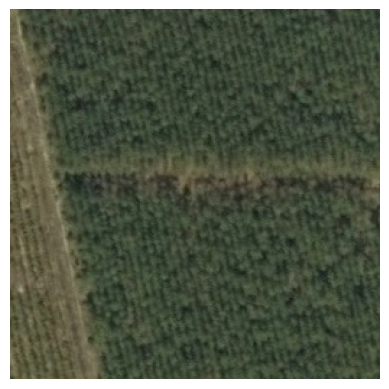

In [17]:
img = Image.open(
    '/Net/Groups/BGI/scratch/ppandey/Side_Quest/semantic-land-segment-hf/artifacts/data_preprocessing/final_dataset/train_images/train/M-33-7-A-d-2-3_patch_0_7.tif'
).convert('RGB')

mask = Image.open(
    '/Net/Groups/BGI/scratch/ppandey/Side_Quest/semantic-land-segment-hf/artifacts/data_preprocessing/final_dataset/train_masks/train/M-33-7-A-d-2-3_patch_0_7.tif'
).convert('L')

plt.imshow(img)
plt.axis(False)

In [117]:
class SegDataLoader:
    def __init__(
        self,
        config: DataLoaderConfig
    ):
        self.config = config
        self.preprocess_input = get_preprocessing_fn(self.config.BACKBONE, pretrained='imagenet')

    def add_single_img_processing(self, img, mask):
        # Scale images
        # scaler = MinMaxScaler()

        batch_size, channels, height, width = img.shape
        img = img.permute(0, 2, 3, 1)
        # img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
        img = self.preprocess_input(img)
        #Convert mask to one-hot
        mask = to_categorical(mask.permute(0, 2, 3, 1), self.config.n_classes)
          
        return (img,mask)
    
    def TrainGenerator(self, data_type: str):
        img_data_transform = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                # transforms.RandomRotation(90),
                transforms.ToTensor(),
                # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # imagenet
            ]
        )

        mask_data_transform = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                # transforms.RandomRotation(90),
                transforms.ToTensor(),
            ]
        )

        if data_type=='train':
            dataset = DataLoaderSegmentation(
                imgs_path=os.path.join(self.config.preprocessed_data_path, 'train_images', data_type),
                masks_path=os.path.join(self.config.preprocessed_data_path, 'train_masks', data_type),
                img_transform=img_data_transform,
                mask_transform=mask_data_transform
            )

        elif data_type=='test':
            dataset = DataLoaderSegmentation(
                imgs_path=os.path.join(self.config.preprocessed_data_path, 'test_images', data_type),
                masks_path=os.path.join(self.config.preprocessed_data_path, 'test_masks', data_type),
                img_transform=img_data_transform,
                mask_transform=mask_data_transform
            )
            
        elif data_type=='val':
            dataset = DataLoaderSegmentation(
                imgs_path=os.path.join(self.config.preprocessed_data_path, 'val_images', data_type),
                masks_path=os.path.join(self.config.preprocessed_data_path, 'val_masks', data_type),
                img_transform=img_data_transform,
                mask_transform=mask_data_transform
            )
        

        train_loader = DataLoader(
        dataset=dataset,
        batch_size=self.config.batch_size,
        shuffle=True,
        num_workers=8,
        drop_last=True,
        worker_init_fn=lambda _: torch.manual_seed(24)
        )

        for img, mask in train_loader:
            img, mask = self.add_single_img_processing(img=img, mask=mask)
            yield (img, mask)

In [118]:
try:
    config = ConfigurationManager()
    data_loader_config = config.get_data_loader_config()
    data_loader = SegDataLoader(config=data_loader_config)
    train_generator = data_loader.TrainGenerator(data_type='train')
except Exception as e:
    raise e

[2024-05-20 20:18:03,548: INFO: common: yaml file: config/config.yaml loaded successfully]
[2024-05-20 20:18:03,569: INFO: common: yaml file: params.yaml loaded successfully]
[2024-05-20 20:18:03,570: INFO: common: created directory at: artifacts]
[2024-05-20 20:18:03,571: INFO: common: created directory at: artifacts/data_loader]


In [119]:
x, y = next(train_generator)

<class 'torch.Tensor'>
torch.Size([3072, 256])


In [120]:
y.shape, x.shape

((4, 256, 256, 5), torch.Size([4, 256, 256, 3]))

[2024-05-20 20:18:08,164: WARNING: image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).]


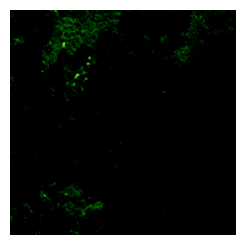

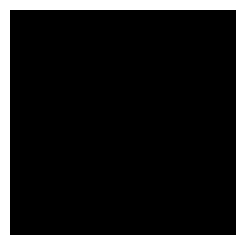

[2024-05-20 20:18:08,244: WARNING: image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).]


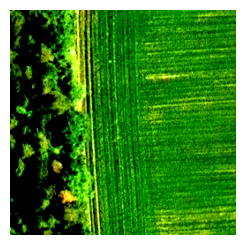

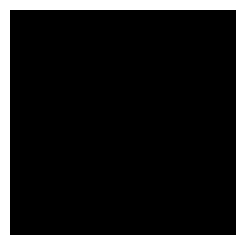

[2024-05-20 20:18:08,346: WARNING: image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).]


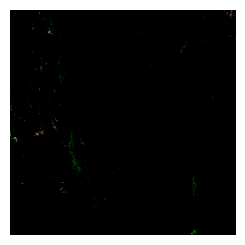

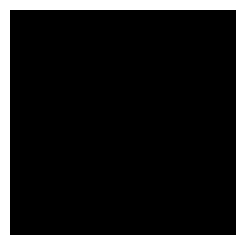

[2024-05-20 20:18:08,401: WARNING: image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).]


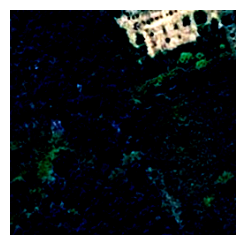

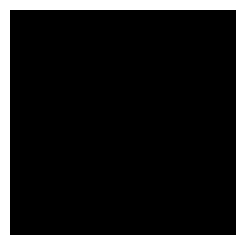

In [121]:
for i in range(0,4):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.axis(False)
    plt.show()
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.axis(False)
    plt.show()